<a href="https://colab.research.google.com/github/hectorvi/Peru2021/blob/main/src/Notebooks/LSTM_Multivariate_Bitcoin_Trend_Prediction-Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM-Multivariate Bitcoin Trend Prediction v.14

# Data Preparation

This dataset was collected from...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Deep Learning/Project'

/content/drive/MyDrive/Deep Learning/Project


In [3]:
ls

'0-Data Preparation.ipynb'
'0-LSTM-Multivariate Bitcoin Price Prediction.ipynb'
 1-pytorch_trend_prediction.ipynb
 2-stock-prediction-pytorch.ipynb
 3-Demo_Predicting_Stock_Prices_with_LSTM.ipynb
 6-predicting-stock-price-using-lstm-model-pytorch.ipynb
 99-Demo_Predicting_Stock_Prices_with_LSTM.ipynb
 AMZN_2006-01-01_to_2018-01-01.csv
 best.pth
 bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
 btcusd.csv
 data_indicators.csv
 data_indicators.txt
'Demo Links  Description.txt'
'LSTM-Multivariate Bitcoin Trend Prediction.ipynb'
 Miniconda3-4.5.4-Linux-x86_64.sh
 rapidsai-csp-utils/


In [4]:
#@title Load Python libraries

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install ta
! pip install --upgrade ta

import pandas as pd

#debug library
! pip install -Uqq ipdb
import ipdb

print("All libraries loaded")

  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=3d379aa8782d484227f9c66e1b81ebd7fb4187de104162d76999eee979cbcb8e
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta
     |████████████████████████████████| 791 kB 8.0 MB/s 
     |████████████████████████████████| 374 kB 68.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.30.1 which is incompatible.
All libraries loaded


In [ ]:
# RAPIDS cuDF 
# https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb#scrollTo=fweFyNRw00So

filepath = '/content/drive/MyDrive/Deep Learning/Project/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
data = pd.read_csv(filepath)


In [ ]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [ ]:
# Converting Timestamp value to Date-Time 

data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.head(500)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
495,2011-12-31 16:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,2011-12-31 16:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,2011-12-31 16:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,2011-12-31 16:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# As used in https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch
data=data.fillna(method='ffill')


In [ ]:
data = data.sort_values('Timestamp')
data.head(500)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.00,4.39
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.00,4.39
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.00,4.39
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.00,4.39
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.00,4.39
...,...,...,...,...,...,...,...,...
495,2011-12-31 16:07:00,4.39,4.39,4.39,4.39,48.000000,210.72,4.39
496,2011-12-31 16:08:00,4.39,4.39,4.39,4.39,48.000000,210.72,4.39
497,2011-12-31 16:09:00,4.39,4.39,4.39,4.39,48.000000,210.72,4.39
498,2011-12-31 16:10:00,4.39,4.39,4.39,4.39,48.000000,210.72,4.39


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Timestamp          datetime64[ns]
 1   Open               float64       
 2   High               float64       
 3   Low                float64       
 4   Close              float64       
 5   Volume_(BTC)       float64       
 6   Volume_(Currency)  float64       
 7   Weighted_Price     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 333.5 MB


In [ ]:
data.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume_btc',
       'volume_currency', 'weighted_price']

In [ ]:
data.shape

(4857377, 8)

In [ ]:
# https://www.dummies.com/personal-finance/investing/3-short-term-cryptocurrency-investing-time-frames/
# But the cryptocurrency market runs 24/7

# Filter data to match each paper

data = data[(data['timestamp'] >= '2020-07-08') & (data['timestamp'] <= '2021-02-11')]    # 300K records, Bitcoin High-Frequency Trend Prediction with Convolutional and Recurrent Neural Networks - from July 8, 2020 to Feb 11, 2021 - Less than a year
#data = data[(data['timestamp'] >= '2018-06-30') & (data['timestamp'] <= '2019-07-30')]  # 500K records, The price series vs. USD, sampled at 1- min intervals over the period from the 1st of July of 2018 to the 30rd of June of 2019, was sourced from the cryptocurrency data provider Cryptocompare.
#data = data[(data['timestamp'] >= '2018-06-30') & (data['timestamp'] <= '2018-12-31')]  # Reduce to 200K records



In [ ]:
data.shape

(313921, 8)

In [ ]:
data.head(500)

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_price
4474336,2020-07-08 00:00:00,9257.21,9265.96,9257.21,9264.19,9.471699,87710.532214,9260.274104
4474337,2020-07-08 00:01:00,9264.29,9267.72,9260.21,9260.21,0.085821,795.220805,9266.033358
4474338,2020-07-08 00:02:00,9260.21,9260.21,9258.93,9258.93,0.049382,457.258061,9259.664373
4474339,2020-07-08 00:03:00,9259.56,9259.56,9253.71,9253.71,0.066542,616.084744,9258.627840
4474340,2020-07-08 00:04:00,9256.92,9256.92,9256.92,9256.92,0.013455,124.551581,9256.920000
...,...,...,...,...,...,...,...,...
4474831,2020-07-08 08:15:00,9300.92,9300.92,9297.60,9297.76,11.423109,106229.457420,9299.522233
4474832,2020-07-08 08:16:00,9297.76,9299.37,9295.19,9295.83,3.191000,29665.773404,9296.699995
4474833,2020-07-08 08:17:00,9295.53,9295.53,9295.53,9295.53,0.200000,1859.106000,9295.530000
4474834,2020-07-08 08:18:00,9295.55,9300.31,9295.55,9300.31,2.020239,18787.341605,9299.561795


In [ ]:
data.tail()

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_price
4788252,2021-02-10 23:56:00,44955.57,44970.49,44930.13,44960.42,2.000709,89934.988349,44951.566261
4788253,2021-02-10 23:57:00,44952.22,44954.43,44924.85,44954.43,2.182300,98055.327786,44932.095317
4788254,2021-02-10 23:58:00,44953.95,44975.76,44902.39,44947.23,3.127892,140537.252450,44930.334848
4788255,2021-02-10 23:59:00,44936.75,44936.75,44854.57,44854.63,2.020059,90645.090475,44872.502087
4788256,2021-02-11 00:00:00,44854.63,44935.63,44854.63,44888.10,2.267979,101776.899510,44875.586324


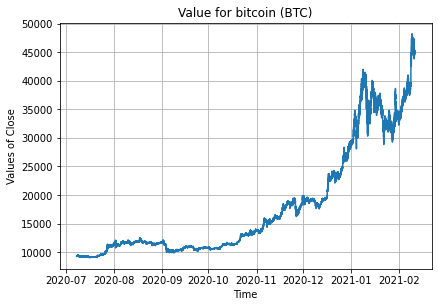

In [ ]:
import matplotlib.dates as mdates

plt.plot(data['timestamp'], data['close'])

plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title('Value for bitcoin (BTC)')
plt.grid()

plt.show()

## Data preparation: add features technical indicators

In [ ]:
# Calculate label or trend

# Binary classification problem (price will go up [1; 0] or down [0; 1]).
data['trend']=np.where(data['close'].shift(-1) > data['close'],1,0)
data.tail()


,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_price,trend
4788252,2021-02-10 23:56:00,44955.57,44970.49,44930.13,44960.42,2.000709,89934.988349,44951.566261,0
4788253,2021-02-10 23:57:00,44952.22,44954.43,44924.85,44954.43,2.182300,98055.327786,44932.095317,0
4788254,2021-02-10 23:58:00,44953.95,44975.76,44902.39,44947.23,3.127892,140537.252450,44930.334848,0
4788255,2021-02-10 23:59:00,44936.75,44936.75,44854.57,44854.63,2.020059,90645.090475,44872.502087,1
4788256,2021-02-11 00:00:00,44854.63,44935.63,44854.63,44888.10,2.267979,101776.899510,44875.586324,0


## Technical indicators
Bitcoin High-Frequency Trend Prediction with Convolutional and Recurrent Neural Networks - 30 technical indicators<br>
Convolution on neural networks for high-frequency trend prediction of cryptocurrency exchange rates using technical indicators - 18 indicators<br>
• Accumulation/Distribution Oscillator (A/D)<br> • Commodity Channel Index (CCI) <br>• Larry William’s R (LWI)<br> • Momentum<br> • Moving average convergence divergence (MACD)<br> • Relative Strength Index (RSI)<br> • Simple n-second moving average (SMA) over 5, 10, 20, 30 and 60 time periods<br> • Stochastic D% (SD)<br> • Stochastic K% (SK)<br> • Weighted n-second moving average (WMA) over 5, 10, 20, 30 and 60 time periods<br>
<a href="https://buildmedia.readthedocs.org/media/pdf/technical-analysis-library-in-python/latest/technical-analysis-library-in-python.pdf" target="_blank">technical-analysis-library-in-python.pdf</a>

In [ ]:
 # https://stackoverflow.com/questions/62150533/can-pandas-dataframe-sort-index-performance-be-improved-on-sorted-data
 data = data.sort_index() 

In [ ]:
# Accumulation/Distribution Oscillator (A/D)
from ta.volume import acc_dist_index
data["ad"] = acc_dist_index(high=data["high"], low=data["low"], close=data["close"], volume=data["volume_btc"])

# Commodity Channel Index (CCI)
from ta.trend import cci
data["cci"] = cci(high=data["high"], low=data["low"], close=data["close"])

# Larry William’s R (LWI)
from ta.momentum import williams_r
data["lwr"] = williams_r(high=data["high"], low=data["low"], close=data["close"])

# Momentum
from ta.momentum import roc
data["mom_roc_30"] = roc(close=data["close"], window=30)

# Moving average convergence divergence (MACD)
from ta.trend import macd
data["macd"] = macd(close=data["close"], window_slow = 26, window_fast = 12)

# Relative Strength Index (RSI)
from ta.momentum import rsi
data["rsi_30"] = rsi(close=data["close"], window=30)

# Simple n-second moving average (SMA) over 5, 10, 20, 30 and 60 time periods
from ta.trend import sma_indicator
data["sma_5"] = sma_indicator(close=data["close"], window=5)
data["sma_10"] = sma_indicator(close=data["close"], window=10)
data["sma_20"] = sma_indicator(close=data["close"], window=20)
data["sma_30"] = sma_indicator(close=data["close"], window=30)
data["sma_60"] = sma_indicator(close=data["close"], window=60)

# Stochastic D% (SD)
from ta.momentum import stochrsi_d
data["sd_30"] = stochrsi_d(close=data["close"], window=30)

# Stochastic K% (SK)
from ta.momentum import stochrsi_k
data["sk_30"] = stochrsi_k(close=data["close"], window=30)

# Weighted n-second moving average (WMA) over 5, 10, 20, 30 and 60 time periods
from ta.trend import wma_indicator
data["wma_5"] = wma_indicator(close=data["close"], window=5)
data["wma_10"] = wma_indicator(close=data["close"], window=10)
data["wma_20"] = wma_indicator(close=data["close"], window=20)
data["wma_30"] = wma_indicator(close=data["close"], window=30)
data["wma_60"] = wma_indicator(close=data["close"], window=60)

In [ ]:
# delete extra day
data.drop(data[data['timestamp'] < '2018-07-01'].index, inplace = True)
data=data.fillna(method='bfill')
print(data.isnull().sum().sum())

0


In [ ]:
# Normalize as mentioned in paper

# TODO normalize using a window for the indicators, see financial samples ?

normalized_data = data[data.columns.difference(['timestamp', 'trend'])]

'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(normalized_data)
'''
#unscaled_data = scaler.inverse_transform(scaled_data)

normalized_data=(normalized_data-normalized_data.mean())/normalized_data.std()
normalized_data['timestamp'] = data['timestamp']

normalized_data['trend'] = data['trend']

first_column = normalized_data.pop('timestamp')
normalized_data.insert(0, 'timestamp', first_column)
normalized_data.set_index(normalized_data.columns[0])
normalized_data = normalized_data.sort_values('timestamp')
normalized_data.tail()


,timestamp,ad,cci,close,high,low,lwr,macd,mom_roc_30,open,rsi_30,sd_30,sk_30,sma_10,sma_20,sma_30,sma_5,sma_60,volume_btc,volume_currency,weighted_price,wma_10,wma_20,wma_30,wma_5,wma_60,trend
4788252,2021-02-10 23:56:00,2.133672,-0.500895,2.807661,2.803683,2.809839,-0.640127,-2.366691,-0.781610,2.807198,-1.063504,-1.056885,-0.839924,2.803715,2.819494,2.826507,2.802824,2.828266,-0.294325,-0.106438,2.807005,2.802597,2.811193,2.818638,2.804234,2.825197,0
4788253,2021-02-10 23:57:00,2.133784,-0.481650,2.807039,2.802015,2.809290,-0.543065,-2.235088,-0.940499,2.806850,-1.097694,-0.858380,-0.632360,2.802503,2.817780,2.825666,2.803864,2.827775,-0.280684,-0.080333,2.804981,2.803241,2.810051,2.817428,2.805672,2.824548,0
4788254,2021-02-10 23:58:00,2.133820,-0.446547,2.806290,2.804230,2.806951,-0.594922,-2.123090,-0.869997,2.807029,-1.139700,-0.727301,-0.663235,2.801869,2.816295,2.824891,2.805468,2.827303,-0.209650,0.056232,2.804798,2.803970,2.809001,2.816223,2.806514,2.823891,0
4788255,2021-02-10 23:59:00,2.133716,-0.636399,2.796662,2.800179,2.801972,-1.265318,-2.221328,-1.121182,2.805241,-1.649959,-0.724686,-0.832248,2.802028,2.814346,2.823885,2.805277,2.826635,-0.292872,-0.104155,2.798784,2.803063,2.807175,2.814448,2.803612,2.822934,1
4788256,2021-02-11 00:00:00,2.133696,-0.545955,2.800142,2.800063,2.801978,-0.919389,-2.197364,-1.239509,2.796702,-1.387521,-0.821204,-0.915774,2.802238,2.812641,2.822768,2.803658,2.826106,-0.274248,-0.068370,2.799104,2.802760,2.805866,2.812961,2.801933,2.822112,0


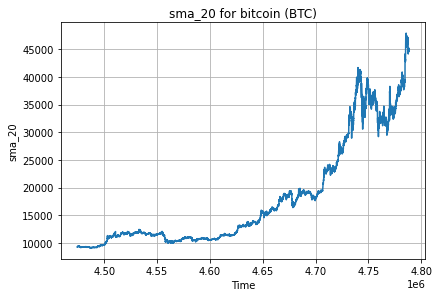

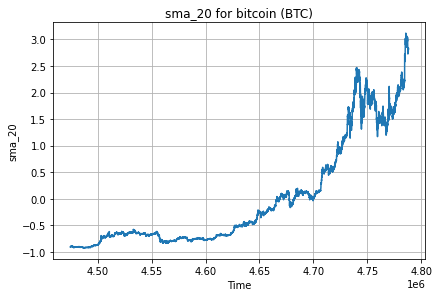

In [ ]:

plt.plot(data['sma_20'])

plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("sma_20")
plt.title('sma_20 for bitcoin (BTC)')
plt.grid()

plt.show()

plt.clf()

plt.plot(normalized_data['sma_20'])

plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("sma_20")
plt.title('sma_20 for bitcoin (BTC)')
plt.grid()

plt.show()

In [ ]:
# Save file locally
# normalized_data.to_csv('data_indicators.csv') 

columns = ["timestamp","ad","cci","close","high","low","lwr","macd","mom_roc_30","open","rsi_30","sd_30","sk_30","sma_10","sma_20","sma_30","sma_5","sma_60",
        "volume_btc","volume_currency","weighted_price","wma_10","wma_20","wma_30","wma_5","wma_60","trend"]
normalized_data.to_csv("data_indicators.txt",header=True,columns=columns) 


In [5]:
# Read dataset

filepath = '/content/drive/MyDrive/Deep Learning/Project/data_indicators.csv'
normalized_data = pd.read_csv(filepath)
#normalized_data1 = normalized_data[normalized_data.columns.difference(['timestamp','Unnamed: 0'])]

normalized_data.pop('timestamp')
# TODO what happens with the index, It is sorted by timestamp ??
normalized_data.pop('Unnamed: 0')

normalized_data.head()


,ad,cci,close,high,low,lwr,macd,mom_roc_30,open,rsi_30,sd_30,sk_30,sma_10,sma_20,sma_30,sma_5,sma_60,volume_btc,volume_currency,weighted_price,wma_10,wma_20,wma_30,wma_5,wma_60,trend
0,-1.336787,NaN,-0.903900,-0.903827,-0.904528,NaN,NaN,NaN,-0.904606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266902,-0.113589,-0.904376,NaN,NaN,NaN,NaN,NaN,0
1,-1.336791,NaN,-0.904314,-0.903645,-0.904216,NaN,NaN,NaN,-0.903870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.438174,-0.392993,-0.903777,NaN,NaN,NaN,NaN,NaN,0
2,-1.336794,NaN,-0.904447,-0.904425,-0.904349,NaN,NaN,NaN,-0.904294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.440911,-0.394080,-0.904440,NaN,NaN,NaN,NaN,NaN,0
3,-1.336797,NaN,-0.904989,-0.904492,-0.904893,NaN,NaN,NaN,-0.904362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.439622,-0.393569,-0.904547,NaN,NaN,NaN,NaN,NaN,1
4,-1.336797,NaN,-0.904656,-0.904766,-0.904559,NaN,NaN,NaN,-0.904636,NaN,NaN,NaN,NaN,NaN,NaN,-0.904472,NaN,-0.443610,-0.395149,-0.904725,NaN,NaN,NaN,-0.904619,NaN,0


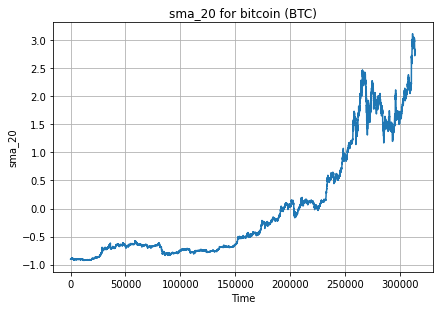

In [6]:
plt.plot(normalized_data['sma_20'])

plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("sma_20")
plt.title('sma_20 for bitcoin (BTC)')
plt.grid()

plt.show()

In [7]:
# Fill nan
normalized_data=normalized_data.fillna(method='bfill')  
normalized_data.head(500)

,ad,cci,close,high,low,lwr,macd,mom_roc_30,open,rsi_30,sd_30,sk_30,sma_10,sma_20,sma_30,sma_5,sma_60,volume_btc,volume_currency,weighted_price,wma_10,wma_20,wma_30,wma_5,wma_60,trend
0,-1.336787,-0.550312,-0.903900,-0.903827,-0.904528,-0.986887,-0.150730,-0.417546,-0.904606,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,0.266902,-0.113589,-0.904376,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
1,-1.336791,-0.550312,-0.904314,-0.903645,-0.904216,-0.986887,-0.150730,-0.417546,-0.903870,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.438174,-0.392993,-0.903777,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
2,-1.336794,-0.550312,-0.904447,-0.904425,-0.904349,-0.986887,-0.150730,-0.417546,-0.904294,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.440911,-0.394080,-0.904440,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
3,-1.336797,-0.550312,-0.904989,-0.904492,-0.904893,-0.986887,-0.150730,-0.417546,-0.904362,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.439622,-0.393569,-0.904547,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,1
4,-1.336797,-0.550312,-0.904656,-0.904766,-0.904559,-0.986887,-0.150730,-0.417546,-0.904636,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.443610,-0.395149,-0.904725,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-1.327816,1.313380,-0.900409,-0.900197,-0.900323,0.549747,0.081293,0.224461,-0.900061,1.402182,1.509092,1.334270,-0.900904,-0.901331,-0.901573,-0.900417,-0.901733,0.413494,-0.054056,-0.900295,-0.900643,-0.901046,-0.901313,-0.900307,-0.901615,0
496,-1.327930,0.882621,-0.900610,-0.900358,-0.900574,0.238990,0.078552,0.169344,-0.900390,1.129504,1.312593,0.929955,-0.900811,-0.901266,-0.901535,-0.900301,-0.901715,-0.204910,-0.300184,-0.900588,-0.900594,-0.900982,-0.901256,-0.900375,-0.901583,0
497,-1.327930,0.611319,-0.900641,-0.900757,-0.900538,0.123075,0.074571,0.130879,-0.900622,1.087218,0.942286,0.502584,-0.900732,-0.901195,-0.901505,-0.900394,-0.901692,-0.429596,-0.389573,-0.900710,-0.900567,-0.900928,-0.901203,-0.900492,-0.901553,1
498,-1.327826,0.862735,-0.900144,-0.900261,-0.900536,0.859697,0.081179,0.307082,-0.900620,1.553273,0.687098,0.584962,-0.900605,-0.901106,-0.901441,-0.900388,-0.901667,-0.292858,-0.335154,-0.900291,-0.900465,-0.900832,-0.901120,-0.900413,-0.901507,1


In [8]:
# drop columns leave indicators only
normalized_data = normalized_data.drop(labels=['open', 'high', 'low', 'close', 'volume_btc','volume_currency', 'weighted_price'], axis=1)
normalized_data.head()

,ad,cci,lwr,macd,mom_roc_30,rsi_30,sd_30,sk_30,sma_10,sma_20,sma_30,sma_5,sma_60,wma_10,wma_20,wma_30,wma_5,wma_60,trend
0,-1.336787,-0.550312,-0.986887,-0.15073,-0.417546,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
1,-1.336791,-0.550312,-0.986887,-0.15073,-0.417546,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
2,-1.336794,-0.550312,-0.986887,-0.15073,-0.417546,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0
3,-1.336797,-0.550312,-0.986887,-0.15073,-0.417546,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,1
4,-1.336797,-0.550312,-0.986887,-0.15073,-0.417546,-2.264339,0.701253,0.524973,-0.904887,-0.905701,-0.906023,-0.904472,-0.906141,-0.905155,-0.906133,-0.906425,-0.904619,-0.906237,0


(313921, 19)

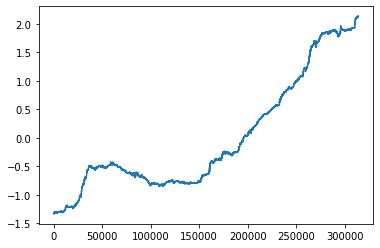

In [9]:
normalized_data["ad"].plot()
normalized_data.shape


##6-predicting-stock-price-using-lstm-model-pytorch.ipynb

In [ ]:
def split_data_windows(stock, lookback, windows):
    data_raw = stock.to_numpy() # convert to numpy array
    window_indices = np.array(range(windows + 1)) * int(len(data_raw) / windows)
    data_windows = []
    
    for i in range(windows):
        windowed_data = data_raw[window_indices[i] : window_indices[i + 1],:]
        data = []
        # create all possible sequences of length seq_len
        for index in range(len(windowed_data) - lookback): 
            data.append(windowed_data[index: index + lookback])
        data = np.array(data);
        
        train_set_size = int(np.round(0.7*data.shape[0]));
        val_set_size = int(np.round(0.15*data.shape[0]));
        test_set_size = int(np.round(0.15*data.shape[0]));

        val_initial_index = train_set_size
        val_final_index = val_initial_index + val_set_size
        test_initial_index = train_set_size + val_set_size
        test_final_index = test_initial_index + val_set_size

        x_train = data[:train_set_size,:-1,:-1]
        y_train = data[:train_set_size,-1,-1:]
        x_val = data[val_initial_index:val_final_index:,:-1,:-1]
        y_val = data[val_initial_index:val_final_index,-1,-1:]
        x_test = data[test_initial_index:test_final_index,:-1,:-1]
        y_test = data[test_initial_index:test_final_index,-1,-1:]
        
        data_windows.append([x_train, y_train, x_val, y_val, x_test, y_test])
    
    return data_windows

In [33]:
def conver_data_to_images(data, lookback):
    data_array = data.to_numpy() # convert to numpy array

    images = []

    # create all possible sequences of length seq_len
    for index in range(len(data_array) - lookback): 
        images.append(data_array[index: index + lookback +1])

    images_array = np.array(images);

    x = images_array[:,:-1,:-1]
    y = images_array[:,-1,-1:]

    return x, y;


In [66]:
from sklearn.model_selection import train_test_split

def split_images(x, y):

  #Source: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

  # Defines ratios, w.r.t. whole dataset.
  ratio_train = 0.7
  ratio_val = 0.15
  ratio_test = 0.15

  # Produces test split.
  x_remaining, x_test, y_remaining, y_test = train_test_split(x, y, test_size=ratio_test)

  # Adjusts val ratio, w.r.t. remaining dataset.
  ratio_remaining = 1 - ratio_test
  ratio_val_adjusted = ratio_val / ratio_remaining

  # Produces train and val splits.
  x_train, x_val, y_train, y_val = train_test_split(x_remaining, y_remaining, test_size=ratio_val_adjusted)

  x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
  y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
  # flattern y
  y_train = torch.flatten(y_train) 

  x_val = torch.from_numpy(x_val).type(torch.Tensor).to(device)
  y_val = torch.from_numpy(y_val).type(torch.Tensor).to(device)
  # flattern y
  y_val = torch.flatten(y_val) 

  x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
  y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
  # flattern y
  y_test = torch.flatten(y_test) 

  return x_train, y_train, x_val, y_val, x_test, y_test
  

In [67]:
x, y = conver_data_to_images(normalized_data, 15)
x_train, y_train, x_val, y_val, x_test, y_test = split_images(x, y)

In [68]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([219734, 15, 18])
torch.Size([219734])
torch.Size([47086, 15, 18])
torch.Size([47086])
torch.Size([47086, 15, 18])
torch.Size([47086])


In [69]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [70]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)
        out = torch.flatten(out) 
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]


In [73]:
# Training Loop

#%pdb on
#%pdb off
#debug
#ipdb.set_trace()

input_dim = 18    
hidden_dim = 256
layer_dim = 2
output_dim = 1
dropout = 0.2

lr = 0.005
n_epochs = 80
batch_size = 100
weight_decay = 0.001

best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, dropout)
model = model.cuda()
criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)

print('Start model training')

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(1, n_epochs + 1):

    losses_epoch_train = []
    losses_epoch_val = []

    # Training Loop
    model.train()    
    correct, total = 0, 0
    train_loss = 0.0

    for beg_i in range(0, x_train.size(0), batch_size):
        x_batch = x_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size]

        opt.zero_grad()
        out = model(x_batch)

        loss = criterion(out, y_batch)

        loss.backward()
        opt.step()

        # Calculate Loss
        #losses_epoch_train.append(loss)
        train_loss += loss.item()*y_batch.size(0)

        total += y_batch.size(0)
        preds = torch.round(out)
        correct += (preds == y_batch).sum().item()
    
    # Store train losses for graph
    avg_loss_train = train_loss/total
    train_losses.append(avg_loss_train)

    acc_train = correct / total
    train_accuracies.append(acc_train)

    # Validation Loop
    model.eval()
    correct, total = 0, 0
    val_loss = 0

    for beg_i in range(0, x_val.size(0), batch_size):
        x_batch = x_val[beg_i:beg_i + batch_size, :]
        y_batch = y_val[beg_i:beg_i + batch_size]

        with torch.no_grad():
          out = model(x_batch)
          out = out.detach()
          loss_val = criterion(out, y_batch)

        # Calculate Loss
        val_loss += loss_val.item()*y_batch.size(0)
        preds = torch.round(out)

        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
  
    # Store train losses for graph
    avg_loss_val = val_loss/total
    val_losses.append(avg_loss_val)

    acc_val = correct / total
    val_accuracies.append(acc_val)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Train Loss: {loss.item():.4f}. Val Acc.: {acc_val:2.2%}')

    if acc_val > best_acc:
        trials = 0
        best_acc = acc_val
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break





Start model training
Epoch 1 best model saved with accuracy: 49.36%
Epoch:   5. Train Loss: 0.6986. Val Acc.: 49.23%
Epoch 6 best model saved with accuracy: 49.39%
Epoch 7 best model saved with accuracy: 51.07%
Epoch:  10. Train Loss: 0.6925. Val Acc.: 51.07%
Epoch:  15. Train Loss: 0.6924. Val Acc.: 48.93%
Epoch:  20. Train Loss: 0.6928. Val Acc.: 51.11%
Epoch 20 best model saved with accuracy: 51.11%
Epoch:  25. Train Loss: 0.6920. Val Acc.: 51.07%
Epoch 26 best model saved with accuracy: 51.22%
Epoch:  30. Train Loss: 0.6921. Val Acc.: 51.07%
Epoch:  35. Train Loss: 0.6920. Val Acc.: 51.07%
Epoch:  40. Train Loss: 0.6982. Val Acc.: 49.34%
Epoch:  45. Train Loss: 0.7030. Val Acc.: 49.32%
Epoch:  50. Train Loss: 0.7069. Val Acc.: 49.34%
Epoch 52 best model saved with accuracy: 51.25%
Epoch:  55. Train Loss: 0.7492. Val Acc.: 49.26%
Epoch:  60. Train Loss: 0.6924. Val Acc.: 51.07%
Epoch:  65. Train Loss: 0.7211. Val Acc.: 49.27%
Epoch:  70. Train Loss: 0.7425. Val Acc.: 49.34%
Epoch:  

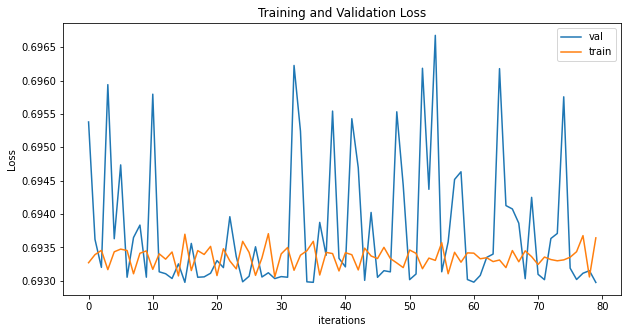

In [75]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

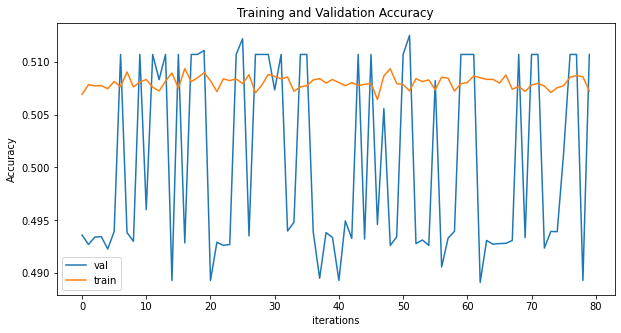

In [76]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies,label="val")
plt.plot(train_accuracies,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [77]:
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, dropout).to(device)
model.load_state_dict(torch.load('best.pth'))

<All keys matched successfully>

In [87]:
  model.eval()
  correct, total = 0, 0
  test_loss = 0

  with torch.no_grad():
    out = model(x_test)
    out = out.detach()
  loss_test = criterion(out, y_test)

# Calculate Loss
test_loss += loss_test.item()*y_test.size(0)
preds = torch.round(out)

total += y_test.size(0)
correct += (preds == y_test).sum().item()

# Store train losses for graph
avg_loss_test = test_loss/total
val_losses.append(avg_loss_test)

acc_test = correct / total

print(f'Test Accuracy: {acc_test:2.2%}') 


Test Accuracy: 51.18%
